# Algorithmic Trading Model for Exponential Moving Average Crossover Take 2
### David Lowe
### May 18, 2020

SUMMARY: The purpose of this project is to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This algorithmic trading model uses the 20-day and 50-day exponential moving averages to generate trading signals. When the fast moving-average curve crosses above the slow moving-average curve, the strategy goes long (buys) on the stock. When the opposite occurs, we will exit the position. We apply the analysis on the GOOG stock for the three years of 2017-01-01 thru 2019-12-31.

In iteration Take1, we constructed and tested a trading strategy using the daily stock data from Yahoo! Finance with an initial investment pool of 1,500 USD.

In this Take2 iteration, we will construct and test a trading strategy using the daily stock data from Alpha Vantage with an initial investment pool of 1,500 USD. We also will leverage the technical indicators available from Alpha Vantage.

ANALYSIS: In iteration Take1, the trading strategy returned 27.94%. In the meantime, the long-only approach achieved an accumulated return of 37.21%.

In this Take2 iteration, the trading strategy returned 27.94%. In the meantime, the long-only approach achieved an accumulated return of 37.21%.

CONCLUSION: For this period, the trading strategy did not outperform the more straightforward long-only approach. We should consider more modeling with different methods for this stock. However, we were able to successfully use the data sources from Alpha Vantage to perform our modeling.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Alpha Vantage

An algorithmic trading modeling project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Acquire and Pre-Process Data
3. Develop Strategy and Train Model
4. Back-test Model
5. Evaluate Performance

## Task 1. Prepare Environment

In [1]:
import os
import sys
import smtplib
import numpy as np
import pandas as pd
import requests
import json
from email.message import EmailMessage
import matplotlib.pyplot as plt
from datetime import datetime
# import pandas_datareader.data as pdr

In [2]:
# Define the function for sending the status notification emails
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if (sender is None) or (receiver is None) or (gateway is None) or (smtpuser is None) or (password is None):
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Algorithmic Trading Modeling Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [3]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting True will activate!)
verbose = False

# Set up the sendNotification flag to send progress emails (setting True will send emails!)
notifyStatus = False

# Configure the plotting style
plt.style.use('seaborn')

In [4]:
if notifyStatus: email_notify("Task 1. Prepare Environment has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [5]:
stock_symbol = 'GOOG'
initial_capital = 1500

model_start_date = datetime(2017, 1, 1)
print("Starting date for the model:", model_start_date)
# end_date = datetime.now()
model_end_date = datetime(2020, 1, 1)
print("Ending date for the model:", model_end_date)

# Specify the parameters for the trading strategy
fast_ma = 20
slow_ma = 50

Starting date for the model: 2017-01-01 00:00:00
Ending date for the model: 2020-01-01 00:00:00


In [6]:
if notifyStatus: email_notify("Task 1. Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2. Acquire and Pre-Process Data

In [7]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [8]:
# Check and see whether the API key is available
alphavantage_key = os.environ.get('ALPHAVANTAGE_API')
if alphavantage_key is None: sys.exit("API key for Alpha Vantage not available. Script Processing Aborted!!!")
alphavantage_url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=%s&outputsize=full&apikey=%s" % (stock_symbol, alphavantage_key)

In [9]:
response = requests.get(alphavantage_url)
alpha_dict = json.loads(response.text)
print(len(alpha_dict['Time Series (Daily)']), 'data points retrieved from the API call.')
if verbose: print(alpha_dict)

1528 data points retrieved from the API call.


In [10]:
rawdata_alpha = pd.DataFrame(alpha_dict['Time Series (Daily)']).T
rawdata_alpha.index = pd.to_datetime(rawdata_alpha.index)
rawdata_alpha = rawdata_alpha.sort_index(ascending = True)
rawdata_alpha.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume', 'dividend', 'split_coef']
rawdata_alpha = rawdata_alpha.astype(float)
stock_alpha = rawdata_alpha[model_start_date:model_end_date]
stock_alpha.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2017-01-03 to 2019-12-31
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   open        754 non-null    float64
 1   high        754 non-null    float64
 2   low         754 non-null    float64
 3   close       754 non-null    float64
 4   adj_close   754 non-null    float64
 5   volume      754 non-null    float64
 6   dividend    754 non-null    float64
 7   split_coef  754 non-null    float64
dtypes: float64(8)
memory usage: 53.0 KB


In [11]:
stock_alpha.head()

,open,high,low,close,adj_close,volume,dividend,split_coef
2017-01-03,778.81,789.6300,775.8000,786.14,786.14,1657268.0,0.0,1.0
2017-01-04,788.36,791.3400,783.1600,786.90,786.90,1072958.0,0.0,1.0
2017-01-05,786.08,794.4800,785.0200,794.02,794.02,1335167.0,0.0,1.0
2017-01-06,795.26,807.9000,792.2041,806.15,806.15,1640170.0,0.0,1.0
2017-01-09,806.40,809.9664,802.8300,806.65,806.65,1274645.0,0.0,1.0


In [12]:
stock_alpha.tail()

,open,high,low,close,adj_close,volume,dividend,split_coef
2019-12-24,1348.50,1350.26,1342.78,1343.56,1343.56,347518.0,0.0,1.0
2019-12-26,1346.17,1361.33,1344.47,1360.40,1360.40,667754.0,0.0,1.0
2019-12-27,1362.99,1364.53,1349.31,1351.89,1351.89,1038718.0,0.0,1.0
2019-12-30,1350.00,1353.00,1334.02,1336.14,1336.14,1051323.0,0.0,1.0
2019-12-31,1330.11,1338.00,1329.09,1337.02,1337.02,962468.0,0.0,1.0


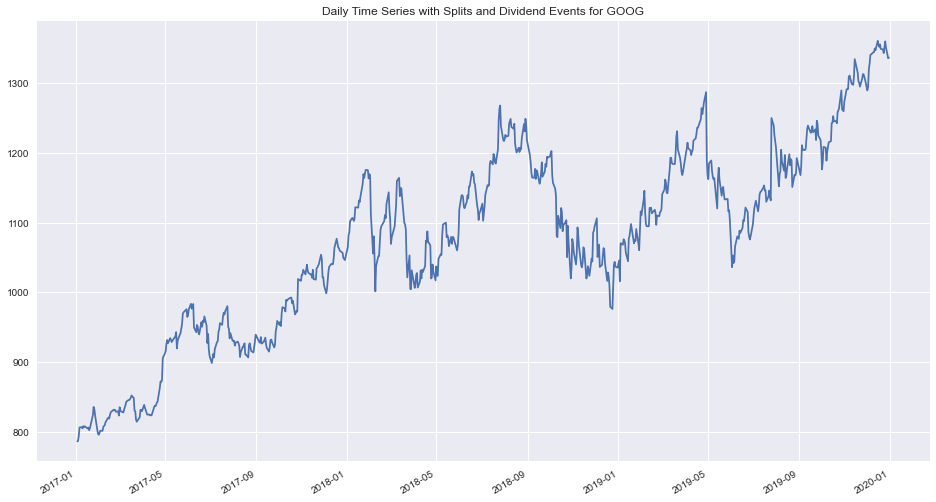

In [13]:
title_string = alpha_dict['Meta Data']['1. Information'] + ' for ' + alpha_dict['Meta Data']['2. Symbol']
stock_alpha['close'].plot(figsize=(16,9), title=title_string)
plt.show()

In [14]:
if notifyStatus: email_notify("Task 2. Acquire and Pre-Process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3. Develop Strategy and Train Model

In [15]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Train Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Set up the Dataframe for the Trading Model

In [16]:
# Select the data source and pricing columns to use for modeling
# trading_model = stock_yahoo.loc[:, ['Open','Adj Close']]
trading_model = stock_alpha.loc[:, ['open','adj_close']]
# trading_model = stock_iexcloud.loc[start_date:end_date, ['close']]
# trading_model = stock_quandl.loc[start_date:end_date, ['Adj_Close']]

# Set up the standard column name for modeling
trading_model.rename(columns={'open': 'open_price', 'adj_close': 'close_price'}, inplace=True)
trading_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2017-01-03 to 2019-12-31
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   open_price   754 non-null    float64
 1   close_price  754 non-null    float64
dtypes: float64(2)
memory usage: 17.7 KB


In [17]:
trading_model.head()

,open_price,close_price
2017-01-03,778.81,786.14
2017-01-04,788.36,786.90
2017-01-05,786.08,794.02
2017-01-06,795.26,806.15
2017-01-09,806.40,806.65


In [18]:
trading_model.tail()

,open_price,close_price
2019-12-24,1348.50,1343.56
2019-12-26,1346.17,1360.40
2019-12-27,1362.99,1351.89
2019-12-30,1350.00,1336.14
2019-12-31,1330.11,1337.02


### 3.b) Set up the Analysis Table with Indicators

In [19]:
def trading_ma_crossover(data):
    wait_for_entry = True
    for x in range(len(data)):
        if data['ma_change'].iloc[x] > 0:
            data['position'].iloc[x] = 1  # Position = 1 means we should take a long position
        else:
            data['position'].iloc[x] = 0  # Position = 0 means we should take a flat or a short position
        if x != 0:
            data['signal_change'].iloc[x] = data['position'].iloc[x] - data['position'].iloc[x-1]
            if wait_for_entry and (data['signal_change'].iloc[x-1] == 1):
                data['entry_exit'].iloc[x] = data['signal_change'].iloc[x-1]
                wait_for_entry = False
            elif (not wait_for_entry) and (data['signal_change'].iloc[x-1] != 0):
                data['entry_exit'].iloc[x] = data['signal_change'].iloc[x-1]

In [20]:
alphavantage_url = "https://www.alphavantage.co/query?function=EMA&symbol=%s&interval=daily&time_period=%d&series_type=close&apikey=%s" % (stock_symbol, fast_ma, alphavantage_key)
response = requests.get(alphavantage_url)
alpha_fast_ma = json.loads(response.text)
print(len(alpha_fast_ma['Technical Analysis: EMA']), 'data points retrieved from the API call.')
if verbose: print(alpha_fast_ma)

1509 data points retrieved from the API call.


In [21]:
rawdata_alpha = pd.DataFrame(alpha_fast_ma['Technical Analysis: EMA']).T
rawdata_alpha.index = pd.to_datetime(rawdata_alpha.index)
rawdata_alpha = rawdata_alpha.sort_index(ascending = True)
rawdata_alpha.columns = ['fast_ma']
rawdata_alpha = rawdata_alpha.astype(float)
rawdata_fast_ma = rawdata_alpha[model_start_date:model_end_date]
rawdata_fast_ma.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2017-01-03 to 2019-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   fast_ma  754 non-null    float64
dtypes: float64(1)
memory usage: 11.8 KB


In [22]:
rawdata_fast_ma.head()

,fast_ma
2017-01-03,783.6990
2017-01-04,784.0038
2017-01-05,784.9578
2017-01-06,786.9761
2017-01-09,788.8498


In [23]:
rawdata_fast_ma.tail()

,fast_ma
2019-12-24,1336.8445
2019-12-26,1339.0879
2019-12-27,1340.3071
2019-12-30,1339.9103
2019-12-31,1339.6350


In [24]:
alphavantage_url = "https://www.alphavantage.co/query?function=EMA&symbol=%s&interval=daily&time_period=%d&series_type=close&apikey=%s" % (stock_symbol, slow_ma, alphavantage_key)
response = requests.get(alphavantage_url)
alpha_slow_ma = json.loads(response.text)
print(len(alpha_slow_ma['Technical Analysis: EMA']), 'data points retrieved from the API call.')
if verbose: print(alpha_slow_ma)

1479 data points retrieved from the API call.


In [25]:
rawdata_alpha = pd.DataFrame(alpha_slow_ma['Technical Analysis: EMA']).T
rawdata_alpha.index = pd.to_datetime(rawdata_alpha.index)
rawdata_alpha = rawdata_alpha.sort_index(ascending = True)
rawdata_alpha.columns = ['slow_ma']
rawdata_alpha = rawdata_alpha.astype(float)
rawdata_slow_ma = rawdata_alpha[model_start_date:model_end_date]
rawdata_slow_ma.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2017-01-03 to 2019-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   slow_ma  754 non-null    float64
dtypes: float64(1)
memory usage: 11.8 KB


In [26]:
rawdata_slow_ma.head()

,slow_ma
2017-01-03,779.0524
2017-01-04,779.3601
2017-01-05,779.9350
2017-01-06,780.9630
2017-01-09,781.9704


In [27]:
rawdata_slow_ma.tail()

,slow_ma
2019-12-24,1304.8590
2019-12-26,1307.0370
2019-12-27,1308.7960
2019-12-30,1309.8683
2019-12-31,1310.9331


In [28]:
trading_model['fast_ma'] = rawdata_fast_ma['fast_ma']
trading_model['slow_ma'] = rawdata_slow_ma['slow_ma']
trading_model['ma_change'] = trading_model['fast_ma'] - trading_model['slow_ma']
trading_model['position'] = np.zeros(len(trading_model))
trading_model['signal_change'] = np.zeros(len(trading_model))
trading_model['entry_exit'] = np.zeros(len(trading_model))
trading_model.head()

,open_price,close_price,fast_ma,slow_ma,ma_change,position,signal_change,entry_exit
2017-01-03,778.81,786.14,783.6990,779.0524,4.6466,0.0,0.0,0.0
2017-01-04,788.36,786.90,784.0038,779.3601,4.6437,0.0,0.0,0.0
2017-01-05,786.08,794.02,784.9578,779.9350,5.0228,0.0,0.0,0.0
2017-01-06,795.26,806.15,786.9761,780.9630,6.0131,0.0,0.0,0.0
2017-01-09,806.40,806.65,788.8498,781.9704,6.8794,0.0,0.0,0.0


In [29]:
trading_model.tail()

,open_price,close_price,fast_ma,slow_ma,ma_change,position,signal_change,entry_exit
2019-12-24,1348.50,1343.56,1336.8445,1304.8590,31.9855,0.0,0.0,0.0
2019-12-26,1346.17,1360.40,1339.0879,1307.0370,32.0509,0.0,0.0,0.0
2019-12-27,1362.99,1351.89,1340.3071,1308.7960,31.5111,0.0,0.0,0.0
2019-12-30,1350.00,1336.14,1339.9103,1309.8683,30.0420,0.0,0.0,0.0
2019-12-31,1330.11,1337.02,1339.6350,1310.9331,28.7019,0.0,0.0,0.0


In [30]:
trading_ma_crossover(trading_model)

# List the Buy signals
trading_model[(trading_model.signal_change != 0) | (trading_model.entry_exit != 0)]

,open_price,close_price,fast_ma,slow_ma,ma_change,position,signal_change,entry_exit
2017-08-10,917.55,907.24,934.1116,934.2282,-0.1166,0.0,-1.0,0.0
2017-09-28,941.36,949.50,930.1406,929.3058,0.8348,1.0,1.0,0.0
2017-09-29,952.00,959.11,932.8996,930.4746,2.4250,1.0,0.0,1.0
2018-03-26,1046.00,1053.21,1096.2837,1096.3039,-0.0202,0.0,-1.0,0.0
2018-03-27,1063.00,1005.10,1087.5995,1092.7272,-5.1277,0.0,0.0,-1.0
2018-05-15,1090.00,1079.23,1061.8823,1061.6995,0.1828,1.0,1.0,0.0
2018-05-16,1077.31,1081.77,1063.7764,1062.4866,1.2898,1.0,0.0,1.0
2018-09-18,1157.09,1161.22,1187.1965,1188.6229,-1.4264,0.0,-1.0,0.0
2018-09-19,1164.98,1171.09,1185.6626,1187.9353,-2.2727,0.0,0.0,-1.0
2018-10-03,1205.00,1202.95,1188.7068,1188.2431,0.4637,1.0,1.0,0.0


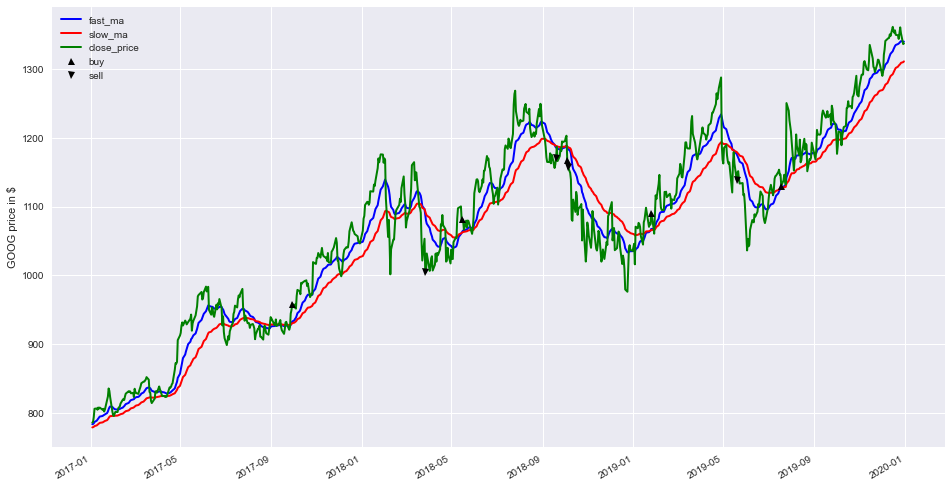

In [31]:
graph_data = trading_model[:]
fig = plt.figure(figsize=(16,9))
ylabel = stock_symbol + ' price in $'
ax1 = fig.add_subplot(111, ylabel=ylabel)
graph_data['fast_ma'].plot(ax=ax1, color='b', lw=2.)
graph_data['slow_ma'].plot(ax=ax1, color='r', lw=2.)
graph_data['close_price'].plot(ax=ax1, color='g', lw=2.)
ax1.plot(graph_data.loc[graph_data.entry_exit == 1].index, graph_data.close_price[graph_data.entry_exit == 1], '^', markersize=7, color='k',label='buy')
ax1.plot(graph_data.loc[graph_data.entry_exit == -1].index, graph_data.close_price[graph_data.entry_exit == -1], 'v', markersize=7, color='k',label='sell')
plt.legend()
plt.show()

In [32]:
if notifyStatus: email_notify("Task 3. Develop Strategy and Train Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4. Back-test Model

In [33]:
if notifyStatus: email_notify("Task 4. Back-test Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [34]:
# Construct a portfolio to track the transactions and returns
portfolio = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cost_basis', 'sold_transaction',
                                                             'gain_loss', 'cash_onhand', 'position_value', 'total_position', 'accumu_return'])
portfolio.iloc[0]['trade_action'] = 0
portfolio.iloc[0]['qty_onhand'] = 0
portfolio.iloc[0]['cost_basis'] = 0.00
portfolio.iloc[0]['sold_transaction'] = 0.00
portfolio.iloc[0]['gain_loss'] = 0.00
portfolio.iloc[0]['cash_onhand'] = initial_capital
portfolio.iloc[0]['position_value'] = 0.00
portfolio.iloc[0]['total_position'] = initial_capital
portfolio.iloc[0]['accumu_return'] = portfolio.iloc[0]['total_position'] - initial_capital
recent_cost = 0

# The conditional parameters below determine how the trading strategy will be carried out
for i in range(1, len(portfolio)):
    if (trading_model.iloc[i]['entry_exit'] == 1) and (portfolio.iloc[i-1]['qty_onhand'] == 0):
        portfolio.iloc[i]['trade_action'] = 1
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['cost_basis'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['sold_transaction'] = 0.00
        portfolio.iloc[i]['gain_loss'] = 0.00
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] - portfolio.iloc[i]['cost_basis']
        recent_cost = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action']
        print('BOUGHT QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
    elif (trading_model.iloc[i]['entry_exit'] == -1) and (portfolio.iloc[i-1]['qty_onhand'] > 0):
        portfolio.iloc[i]['trade_action'] = -1
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand'] + portfolio.iloc[i]['trade_action']
        portfolio.iloc[i]['cost_basis'] = 0.00
        portfolio.iloc[i]['sold_transaction'] = trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'] * -1
        portfolio.iloc[i]['gain_loss'] = (recent_cost + (trading_model.iloc[i]['open_price'] * portfolio.iloc[i]['trade_action'])) * -1
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand'] + portfolio.iloc[i]['sold_transaction']
        recent_cost = 0.00
        print('SOLD QTY:', portfolio.iloc[i]['trade_action'], 'on', portfolio.index[i], 'at the price of', trading_model.iloc[i]['open_price'])
    else:
        portfolio.iloc[i]['trade_action'] = 0
        portfolio.iloc[i]['qty_onhand'] = portfolio.iloc[i-1]['qty_onhand']
        portfolio.iloc[i]['cost_basis'] = portfolio.iloc[i-1]['cost_basis']
        portfolio.iloc[i]['sold_transaction'] = 0.00
        portfolio.iloc[i]['gain_loss'] = 0.00
        portfolio.iloc[i]['cash_onhand'] = portfolio.iloc[i-1]['cash_onhand']
    portfolio.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * portfolio.iloc[i]['qty_onhand']
    portfolio.iloc[i]['total_position'] = portfolio.iloc[i]['cash_onhand'] + portfolio.iloc[i]['position_value']
    portfolio.iloc[i]['accumu_return'] = portfolio.iloc[i]['total_position'] - initial_capital

BOUGHT QTY: 1 on 2017-09-29 00:00:00 at the price of 952.0
SOLD QTY: -1 on 2018-03-27 00:00:00 at the price of 1063.0
BOUGHT QTY: 1 on 2018-05-16 00:00:00 at the price of 1077.31
SOLD QTY: -1 on 2018-09-19 00:00:00 at the price of 1164.98
BOUGHT QTY: 1 on 2018-10-04 00:00:00 at the price of 1195.33
SOLD QTY: -1 on 2018-10-05 00:00:00 at the price of 1167.5
BOUGHT QTY: 1 on 2019-01-25 00:00:00 at the price of 1085.0
SOLD QTY: -1 on 2019-05-20 00:00:00 at the price of 1144.5
BOUGHT QTY: 1 on 2019-07-19 00:00:00 at the price of 1148.19


In [35]:
portfolio[portfolio.trade_action == 1]

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
2017-09-29,1,1,952,0,0,548,959.11,1507.11,7.11
2018-05-16,1,1,1077.31,0,0,533.69,1081.77,1615.46,115.46
2018-10-04,1,1,1195.33,0,0,503.34,1168.19,1671.53,171.53
2019-01-25,1,1,1085,0,0,585.84,1090.99,1676.83,176.83
2019-07-19,1,1,1148.19,0,0,582.15,1130.1,1712.25,212.25


In [36]:
portfolio[portfolio.trade_action == -1]

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
2018-03-27,-1,0,0,1063,111,1611,0,1611,111
2018-09-19,-1,0,0,1164.98,87.67,1698.67,0,1698.67,198.67
2018-10-05,-1,0,0,1167.5,-27.83,1670.84,0,1670.84,170.84
2019-05-20,-1,0,0,1144.5,59.5,1730.34,0,1730.34,230.34


In [37]:
portfolio.head(20)

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
2017-01-03,0,0,0,0,0,1500,0,1500,0
2017-01-04,0,0,0,0,0,1500,0,1500,0
2017-01-05,0,0,0,0,0,1500,0,1500,0
2017-01-06,0,0,0,0,0,1500,0,1500,0
2017-01-09,0,0,0,0,0,1500,0,1500,0
2017-01-10,0,0,0,0,0,1500,0,1500,0
2017-01-11,0,0,0,0,0,1500,0,1500,0
2017-01-12,0,0,0,0,0,1500,0,1500,0
2017-01-13,0,0,0,0,0,1500,0,1500,0
2017-01-17,0,0,0,0,0,1500,0,1500,0


In [38]:
portfolio.tail(20)

,trade_action,qty_onhand,cost_basis,sold_transaction,gain_loss,cash_onhand,position_value,total_position,accumu_return
2019-12-03,0,1,1148.19,0,0,582.15,1295.28,1877.43,377.43
2019-12-04,0,1,1148.19,0,0,582.15,1320.54,1902.69,402.69
2019-12-05,0,1,1148.19,0,0,582.15,1328.13,1910.28,410.28
2019-12-06,0,1,1148.19,0,0,582.15,1340.62,1922.77,422.77
2019-12-09,0,1,1148.19,0,0,582.15,1343.56,1925.71,425.71
2019-12-10,0,1,1148.19,0,0,582.15,1344.66,1926.81,426.81
2019-12-11,0,1,1148.19,0,0,582.15,1345.02,1927.17,427.17
2019-12-12,0,1,1148.19,0,0,582.15,1350.27,1932.42,432.42
2019-12-13,0,1,1148.19,0,0,582.15,1347.83,1929.98,429.98
2019-12-16,0,1,1148.19,0,0,582.15,1361.17,1943.32,443.32


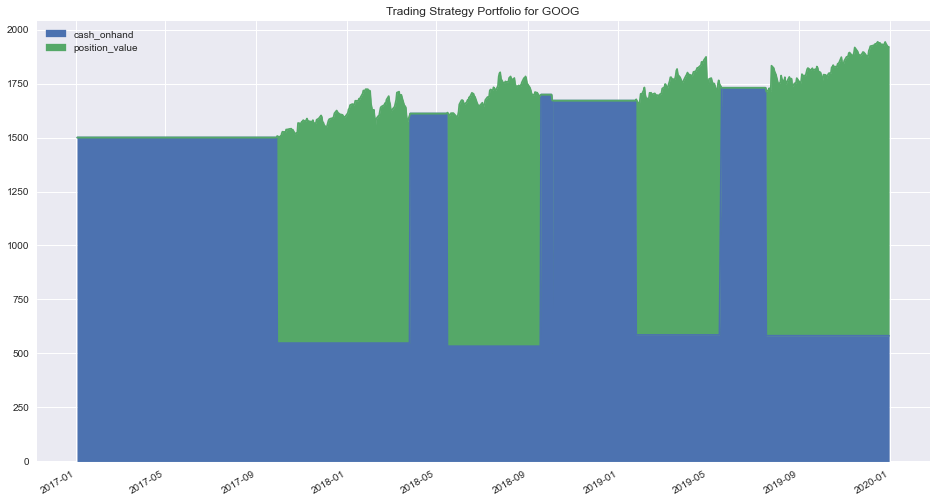

In [39]:
title_string = 'Trading Strategy Portfolio for ' + stock_symbol
portfolio[['cash_onhand','position_value']].plot.area(figsize=(16,9), stacked=True)
plt.title(title_string)
plt.show()

In [40]:
if notifyStatus: email_notify("Task 4. Back-test Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5. Evaluate Performance

In [41]:
if notifyStatus: email_notify("Task 5. Evaluate Performance has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [42]:
# Construct a long only as a benchmark for the trading strategy
benchmark = pd.DataFrame(index=trading_model.index, columns=['trade_action', 'qty_onhand', 'cash_onhand', 'position_value', 'total_position', "accumu_return"])
benchmark.iloc[0]['trade_action'] = 1
benchmark.iloc[0]['qty_onhand'] = benchmark.iloc[0]['trade_action']
benchmark.iloc[0]['cash_onhand'] = initial_capital - (trading_model.iloc[0]['open_price'] * benchmark.iloc[0]['trade_action'])
benchmark.iloc[0]['position_value'] = trading_model.iloc[0]['open_price']
benchmark.iloc[0]['total_position'] = initial_capital
benchmark.iloc[0]['accumu_return'] = benchmark.iloc[0]['total_position'] - initial_capital

for i in range(1, len(portfolio)):
    benchmark.iloc[i]['trade_action'] = 0
    benchmark.iloc[i]['qty_onhand'] = benchmark.iloc[i-1]['qty_onhand']
    benchmark.iloc[i]['cash_onhand'] = benchmark.iloc[i-1]['cash_onhand']
    benchmark.iloc[i]['position_value'] = trading_model.iloc[i]['close_price'] * benchmark.iloc[i]['qty_onhand']
    benchmark.iloc[i]['total_position'] = benchmark.iloc[i]['cash_onhand'] + benchmark.iloc[i]['position_value']
    benchmark.iloc[i]['accumu_return'] = benchmark.iloc[i]['total_position'] - initial_capital

benchmark.head(10)

,trade_action,qty_onhand,cash_onhand,position_value,total_position,accumu_return
2017-01-03,1,1,721.19,778.81,1500,0
2017-01-04,0,1,721.19,786.9,1508.09,8.09
2017-01-05,0,1,721.19,794.02,1515.21,15.21
2017-01-06,0,1,721.19,806.15,1527.34,27.34
2017-01-09,0,1,721.19,806.65,1527.84,27.84
2017-01-10,0,1,721.19,804.79,1525.98,25.98
2017-01-11,0,1,721.19,807.91,1529.1,29.1
2017-01-12,0,1,721.19,806.36,1527.55,27.55
2017-01-13,0,1,721.19,807.88,1529.07,29.07
2017-01-17,0,1,721.19,804.61,1525.8,25.8


In [43]:
benchmark.tail(10)

,trade_action,qty_onhand,cash_onhand,position_value,total_position,accumu_return
2019-12-17,0,1,721.19,1355.12,2076.31,576.31
2019-12-18,0,1,721.19,1352.62,2073.81,573.81
2019-12-19,0,1,721.19,1356.04,2077.23,577.23
2019-12-20,0,1,721.19,1349.59,2070.78,570.78
2019-12-23,0,1,721.19,1348.84,2070.03,570.03
2019-12-24,0,1,721.19,1343.56,2064.75,564.75
2019-12-26,0,1,721.19,1360.4,2081.59,581.59
2019-12-27,0,1,721.19,1351.89,2073.08,573.08
2019-12-30,0,1,721.19,1336.14,2057.33,557.33
2019-12-31,0,1,721.19,1337.02,2058.21,558.21


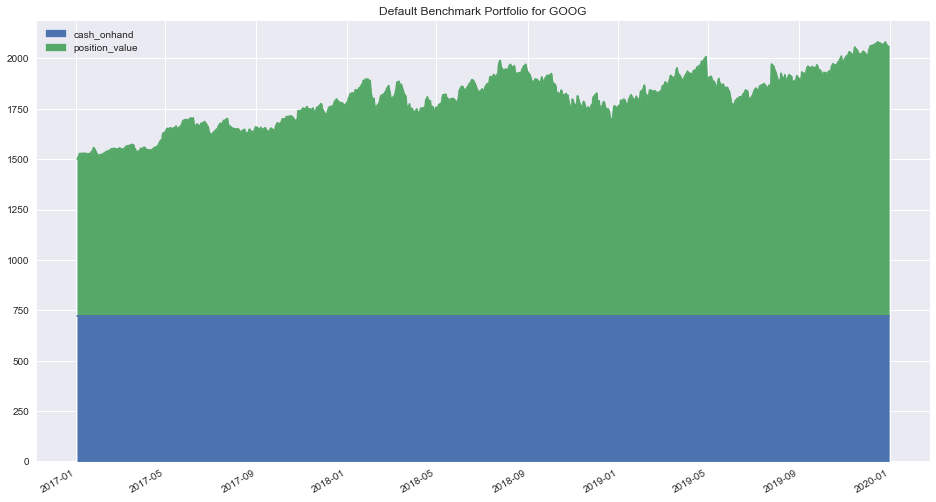

In [44]:
title_string = 'Default Benchmark Portfolio for ' + stock_symbol
benchmark[['cash_onhand','position_value']].plot.area(figsize=(16,9), stacked=True)
plt.title(title_string)
plt.show()

In [45]:
# Build a performance data frame to display the returns from the strategy and benchmark
performance = pd.DataFrame(index=trading_model.index)
performance['strategy'] = portfolio['accumu_return']
performance['benchmark'] = benchmark['accumu_return']

performance.tail(10)

,strategy,benchmark
2019-12-17,437.27,576.31
2019-12-18,434.77,573.81
2019-12-19,438.19,577.23
2019-12-20,431.74,570.78
2019-12-23,430.99,570.03
2019-12-24,425.71,564.75
2019-12-26,442.55,581.59
2019-12-27,434.04,573.08
2019-12-30,418.29,557.33
2019-12-31,419.17,558.21


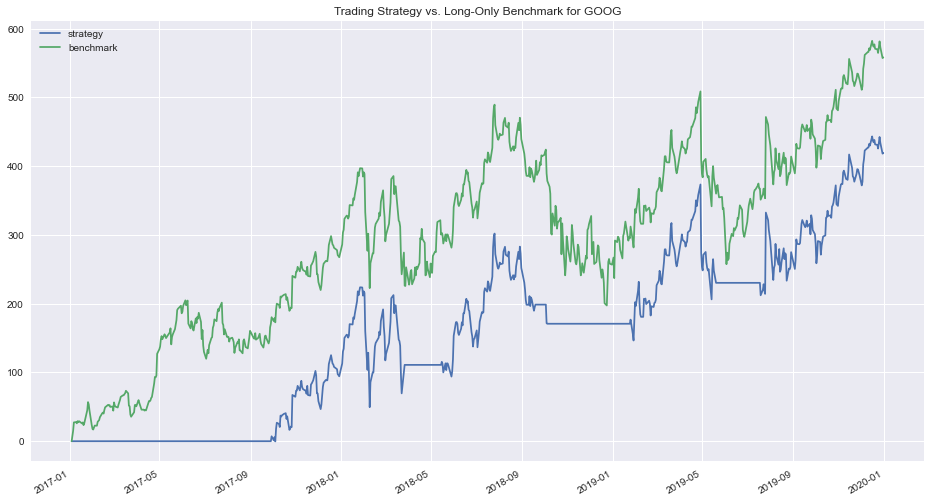

In [46]:
title_string = 'Trading Strategy vs. Long-Only Benchmark for ' + stock_symbol
performance[['strategy','benchmark']].plot(figsize=(16,9), title=title_string)
plt.show()

In [47]:
print('The accumulated return/loss from the trading strategy: %.2f percent' % (performance.iloc[-1]['strategy'] / initial_capital * 100))
print('The accumulated return/loss from the long-only benchmark: %.2f percent' % (performance.iloc[-1]['benchmark'] / initial_capital * 100))

The accumulated return/loss from the trading strategy: 27.94 percent
The accumulated return/loss from the long-only benchmark: 37.21 percent


In [48]:
if notifyStatus: email_notify("Task 5. Evaluate Performance completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [49]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:38.656898
